# ML Experiments

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Factorial design (Grid search) 

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

X = (X-X.mean())/X.std()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [4]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

res = []

for d in range(1, X.shape[1]+1):
    for k in range(1, 15, 2):
        X_train_pca = PCA(n_components=d).fit_transform(X_train)
        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_pca, Y_train)

        X_test_pca = PCA(n_components=d).fit_transform(X_test)
        acc = knn.score(X_test_pca, Y_test)
        res.append([d, k, acc])

<AxesSubplot: xlabel='d', ylabel='k'>

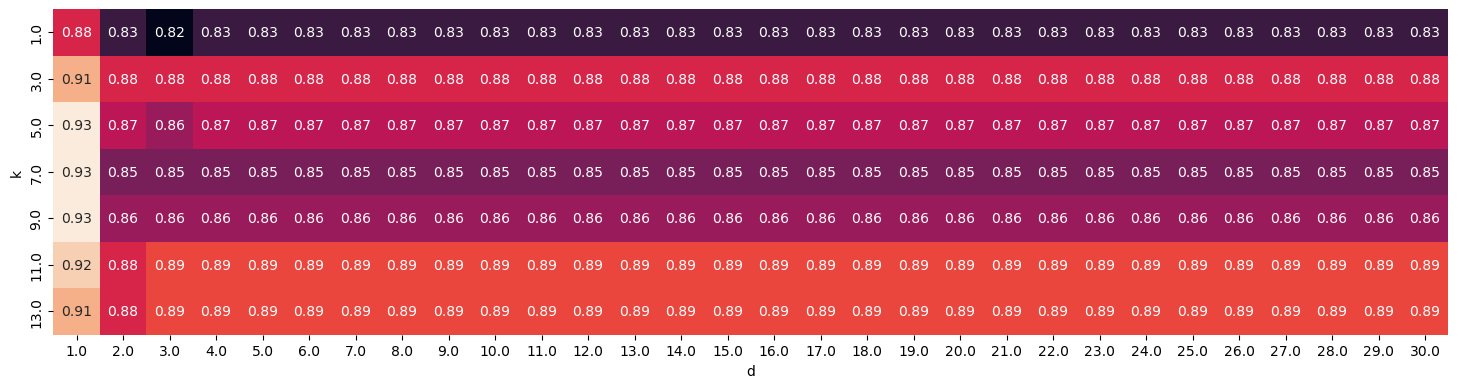

In [9]:
res_df = pd.DataFrame(np.array(res), columns=['d', 'k', 'acc'])

res_df_pivot = res_df.pivot(index='k', columns='d', values='acc')

fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(ax=ax, data=res_df_pivot, cbar=False, annot=True, square=True, fmt=".2f")

## Compare two classifiers

In [10]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_rel
from sklearn.model_selection import train_test_split

p_values = []

for _ in range(100):
    acc_lr = []
    acc_dt = []

    for _ in range(10):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)
        lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
        dt = DecisionTreeClassifier().fit(X_train, Y_train)

        acc_lr.append(lr.score(X_test, Y_test))
        acc_dt.append(dt.score(X_test, Y_test))

    acc_dt = np.array(acc_dt)
    acc_lr = np.array(acc_lr)

    p_values.append(ttest_rel(acc_dt, acc_lr).pvalue)


power=0.82


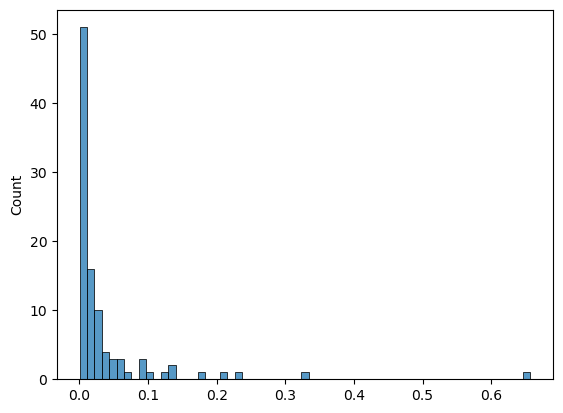

In [12]:
p_values = np.array(p_values)

sns.histplot(p_values)
power = np.sum(p_values < 0.05)/p_values.shape[0]
print(f"{power=}")

## Average of samples + Z-normalisation

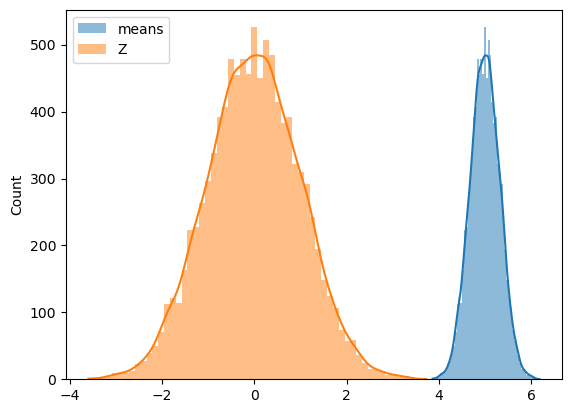

In [13]:

means = np.array([np.random.normal(5, 1, size=10).mean() for _ in range(10000)])

sns.histplot(data=means, label='means', kde=True, ec=None)
sns.histplot(data=(means - 5)/(1/10**0.5), label='Z', kde=True, ec=None)
plt.legend()

## Basic hypothesis test two-sided

<AxesSubplot: ylabel='Count'>

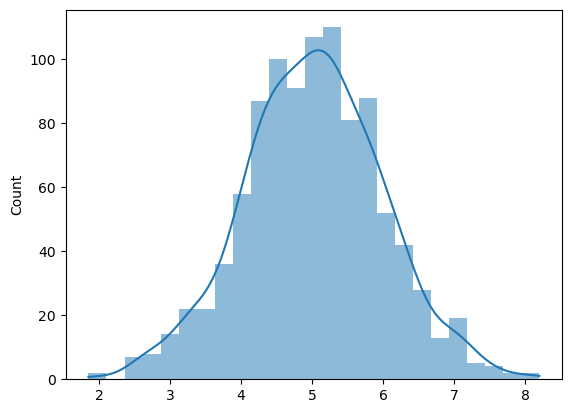

In [23]:
mu = 5
var = 1
N = 1000
sample = np.random.normal(mu, var, size=N)
sns.histplot(data=sample, kde=True, ec=None)

$H_0: \mu = \mu_0$

$H_1: \mu \neq \mu_0$

$
    \text{If}\quad \frac{\sqrt{N} (m - \mu_0)}{\sigma} \in (-1.96, 1.96) \quad\text{ then with 95\% confidence, we fail to reject } H_0
$

In [24]:
mu0 = 8
z_stat = N**.5 * (sample.mean() - mu0) / var**.5
print(f"with {mu0=}")
print(f"{z_stat=}")
print(f"falls within 95% interval (-1.96, 1.96)? {'yes, fail to reject H0' if -1.96 < z_stat < 1.96 else 'no, reject H0'}")

print()

mu0 = 5
z_stat = N**.5 * (sample.mean() - mu0) / var**.5
print(f"with {mu0=}")
print(f"{z_stat=}")
print(f"falls within 95% interval (-1.96, 1.96)? {'yes, fail to reject H0' if -1.96 < z_stat < 1.96 else 'no, reject H0'}")


with mu0=8
z_stat=-94.26010041350676
falls within 95% interval (-1.96, 1.96)? no, reject H0

with mu0=5
z_stat=0.6082293915446151
falls within 95% interval (-1.96, 1.96)? yes, fail to reject H0


## Binomial test

Assume $H_0: p \leq p_0$ with the alternative $H_1: p > p_0$.

In [162]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.special import comb

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
p = np.sum(lr.predict(X_test) != Y_test)/Y_test.shape[0]
N = Y_test.shape[0]
print(f"probability of misclassification: {p=}")
print(f"errors e={np.sum(lr.predict(X_test) != Y_test)}")
print(f"{N=}")

probability of misclassification: p=0.043859649122807015
errors e=5
N=114


In [163]:
p0 = 0.01 
N = 114
e = 5
p_X_e = sum([comb(N, x) * p0**x * (1-p0)**(N-x) for x in range(e, N)])
p_X_e # 0.005 < 0.05 (alpha), therefore reject H0

0.005971392744805069

if $p_0 = 0.01$, then with $N=114$ we have the probability of making $e=5$ or more errors as 
$$
    P(X \geq 5) = 0.00597
$$
Since $P(X \geq e) < \alpha$ where $\alpha = 0.05$, we reject $H_0$. This means that the true misclassification error $p$ is with $95\%$ confidence larger than $p_0$

We try again with $p_0 = 0.05$

In [165]:
p0 = 0.05 
N = 114
e = 5
p_X_e = sum([comb(N, x) * p0**x * (1-p0)**(N-x) for x in range(e, N)])
p_X_e # 0.679 > 0.05 (alpha), therefore fail to reject H0

0.6792110747756429

Now we see that $P(X \geq 5) = 0.67921$ which is not smaller than $\alpha$

$P(X \geq 5) < \alpha$ is false 

and we fail to reject $H_0: p \leq p_0$. 

we can make the upper bound $p_0$ smaller until we reject $H_0$ again, and find a closer approximation of the true $p$

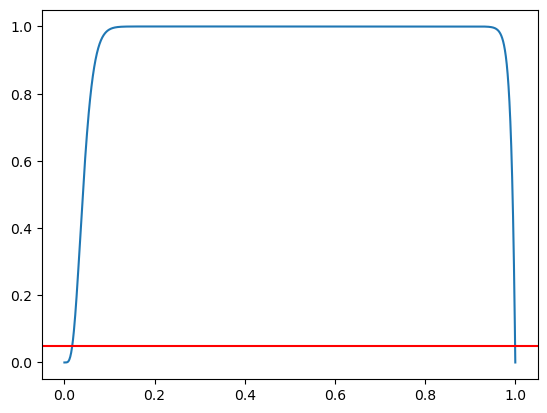

In [167]:
p0 = np.linspace(0, 1, 1000)
N = 114
e = 5

p_X_e = sum([comb(N, x) * p0**x * (1-p0)**(N-x) for x in range(e, N)])

fig, ax = plt.subplots()
sns.lineplot(ax=ax, x=p0, y=p_X_e)
ax.axhline(y=0.05, c='r')

## Approximate normal Test

- Compute probability of error as point estimate $\hat{p} = X/N$
- null hypothesis $H_0: p \leq p_0$ vs $H_1: p > p_0 $
- $X/N$ is approximately normal distributed with mean $p_0$ and variance $p_0(1-p_0)/N$

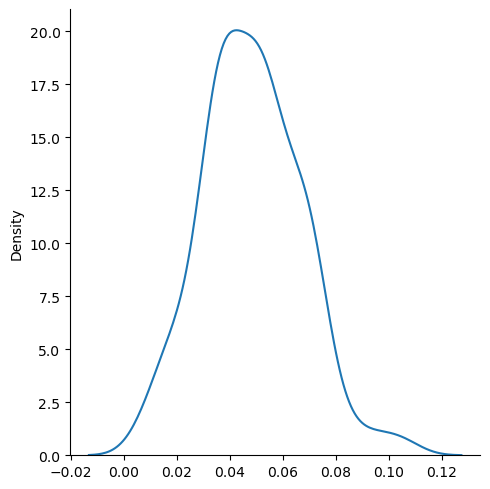

In [199]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

p_hats = []
replications = range(1, 100)

for _ in replications:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

    lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
    N = Y_test.shape[0]
    p_hat = np.sum(lr.predict(X_test) != Y_test)/N
    p_hats.append(p_hat)

p_hats = np.array(p_hats)
sns.displot(p_hats, kind='kde')

In [201]:
p0 = p_hats.mean()
var = p0*(1-p0)/N
p0, var

(0.04828991671096934, 0.000403140356622956)

Reject $H_0$ if $Z$ statistic for $X = e$ is greater than $z_\alpha$, where $z_{0.05} = 1.64$

In [221]:
N = Y.shape[0]
e = 9 # number of misclassifications

z = (e/N - p0)/np.sqrt(var)
z

-1.6172984700687125

when number of misclassifications is 47, then with 95% confidence we reject H0: p <= p0


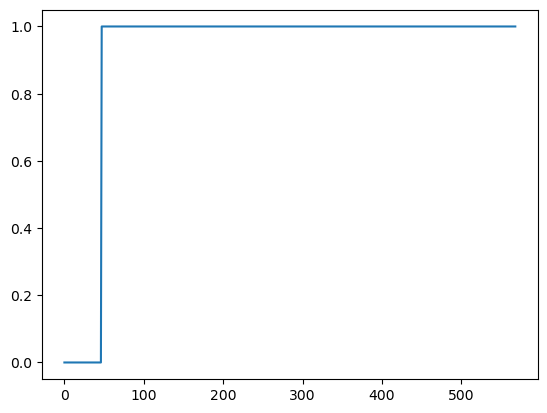

In [225]:
N = Y.shape[0]
e = np.arange(0, N, 1) # number of misclassifications

z = (e/N - p0)/np.sqrt(var) > 1.64
sns.lineplot(x=e, y=z)
error_threshold = np.argmax(z)

print(f"when number of misclassifications is {error_threshold}, then with 95% confidence we reject H0: p <= p0")

## t Test

In [237]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

p_hats = []
K = 30
replications = range(0, K)

for _ in replications:
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

    lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
    N = Y_test.shape[0]
    p_hat = np.sum(lr.predict(X_test) != Y_test)/N
    p_hats.append(p_hat)

p_hats = np.array(p_hats)

m = p_hats.mean()
S2 = np.sum((p_hats - m)**2)/(K-1)
m, S2

(0.045614035087719294, 0.00029929633521189535)

0.04040404040404041

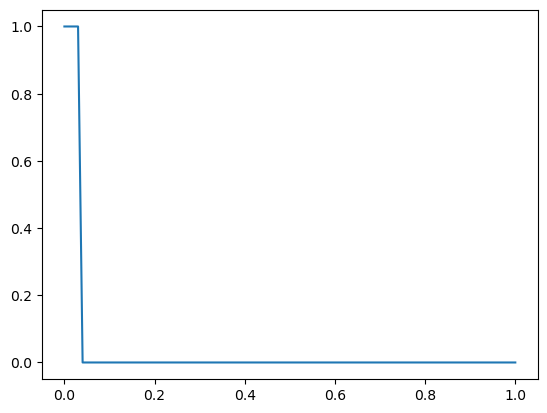

In [245]:
p0 = np.linspace(0, 1, 100)

t_stat = np.sqrt(K) * (m-p0) / np.sqrt(S2)
sns.lineplot(x=p0, y=t_stat>1.7)
p0_bound_index = np.argmax(t_stat<=1.7)
p0_bound = p0[p0_bound_index]
p0_bound

## McNemar's Test

In [285]:
truth = np.array([1, 1, 0])

y_0 = np.array([1, 1, 0])
y_1 = np.array([0, 1, 0])

(y_0 != truth)*1, (y_1 != truth)*1, np.logical_xor((y_0 != truth)*1,  (y_1 != truth)*1) & (y_1 != truth)*1, 
(y_0 != truth)*1, (y_1 != truth)*1, (~(y_1 != truth))

(array([0, 0, 0]), array([1, 0, 0]), array([False,  True,  True]))

In [333]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
err_lr = lr.predict(X_test) != Y_test

dt = DecisionTreeClassifier(max_depth=1).fit(X_train, Y_train)
err_dt = dt.predict(X_test) != Y_test

# frequencies of errors between both classifiers
err_01 = np.sum(np.logical_xor(err_lr, err_dt) & err_lr)
err_10 = np.sum(np.logical_xor(err_lr, err_dt) & err_dt)
err_00 = np.sum(err_lr & err_dt)
err_11 = np.sum(~err_lr & ~err_dt)

# matrix of errors
errs = np.array([[err_00, err_01], [err_10, err_11]])
errs, lr.score(X_test, Y_test), dt.score(X_test, Y_test)

(array([[  4,   1],
        [  8, 101]]),
 0.956140350877193,
 0.8947368421052632)

In [334]:
chi2_stat = (np.abs(err_01 - err_10) - 1)**2 / (err_01 + err_10)

if chi2_stat > 3.84:
    print(f"reject H0: error_lr == error_dt, because {chi2_stat=} is larger than 3.84 for alpha = 0.05")
else:
    print(f"fail to reject H0: error_lr == error_dt, because {chi2_stat=} is less than or equal to 3.84 for alpha = 0.05")

reject H0: error_lr == error_dt, because chi2_stat=4.0 is larger than 3.84 for alpha = 0.05


## K-fold CV paired t-test

- $H_0: \mu = 0, \qquad H_1: \mu \neq 0$, 
- where $\mu$ is the mean of the difference between the error rates $p_i^1, p_i^2$,
- difference: $p_i = p_i^1 - p_i^2$
- point estimate mean of differences: $m = \sum_i p_i / K$ 

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

p_i = []

K = 10
kf = KFold(n_splits=K)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
    dt = DecisionTreeClassifier(max_depth=1).fit(X_train, Y_train)

    p_i.append((1-lr.score(X_test, Y_test)) - (1-dt.score(X_test, Y_test)))

p_i = np.array(p_i)

In [3]:
m = p_i.mean()

S_2 = np.sum((p_i - m)**2)/(K-1)

t_stat = (K**.5 * m)/S_2**.5
t_stat

-5.559968100722705

Reject if $t \not\in (-2.26, 2.26)$ for $K=10$

## ANOVA

In [45]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

learners = {
    'lr': LogisticRegression(solver='liblinear'),
    'dt': DecisionTreeClassifier(), 
    'nn3': KNeighborsClassifier(n_neighbors=3), 
    'nn5': KNeighborsClassifier(n_neighbors=5), 
    'nn7': KNeighborsClassifier(n_neighbors=7), 
}

errs = {l: [] for l in learners.keys()}

K = 10
replications = range(0, K)

for l in errs.keys():
    learner = learners[l]
    for _ in replications:

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)
        clf = learner.fit(X_train, Y_train)
        errs[l].append(np.sum(clf.predict(X_test) != Y_test))

errs = pd.DataFrame(errs)


In [50]:
mjs = errs.mean()
m = mjs.mean()
L = errs.shape[1]
S_2 = np.sum((mjs - m)**2 / (L-1))
sigma2b = K * S_2
SSb = K * np.sum((mjs - m)**2)

print(f"Estimates assuming H0 is true:")
print(f"\t{m=}")
print(f"\t{S_2=}")
print(f"\t{sigma2b=}")
print(f"\t{SSb=}")

print()

S_2j = np.sum((errs - mjs)**2)/(K-1)
sigma2w = np.sum(S_2j/L)
SSw = np.sum((errs - mjs)**2).sum()

print(f"Estimates regardless of H0 being true:")
print(f"\t{sigma2w=}")
print(f"\t{SSw=}")

print()
print(f"ratio between sigma_b^2/sigma_w^2: F0 = {sigma2b/sigma2w}")

Estimates assuming H0 is true:
	m=7.56
	S_2=1.3630000000000004
	sigma2b=13.630000000000004
	SSb=54.52000000000002

Estimates regardless of H0 being true:
	sigma2w=6.262222222222222
	SSw=281.8

ratio between sigma_b^2/sigma_w^2: F0 = 2.1765436479772897


ratio if $F$-distributed and if $F_0 > F_{\alpha, L-1, L(K-1)}$ then reject $H_0$ that says that the means of all learners is not equal. 

In [51]:
# total sum of squares SSt
np.sum((errs - m)**2).sum(), SSb+SSw

(336.31999999999994, 336.32000000000005)

In [61]:
from scipy.stats import f_oneway

# validation with scipy
f_oneway(*[errs[l] for l in errs.columns])

F_onewayResult(statistic=2.176543647977288, pvalue=0.08688573221114042)

## ROC Curve

In [186]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

lr = LogisticRegression(solver='liblinear').fit(X_train, Y_train)
dt = DecisionTreeClassifier().fit(X_train, Y_train)
kn = KNeighborsClassifier().fit(X_train, Y_train)

- true positive rate (TPR): number of correct positive predictions, 
$$
    TPR = \frac{1}{N} \sum_i (1(\hat{y}_i > \theta) \land y_i)
$$
- false positive rate (FPR): number of incorrect positive predictions
$$
    FPR = \frac{1}{N} \sum_i (1(\hat{y}_i > \theta) \land \neg y_i)
$$
- Area under the curve, sort FPR (x-axis) in increasing order, then
$$
    \text{Area} = \frac{1}{2} \sum_i (FPR_{i+1} - FPR_{i}) (TPR_{i+1} + TPR_i)
$$
$(FPR_{i+1} - FPR_{i})$ are the differences between subsequent FPR values for $\theta \in (0, 1)$

$(TPR_{i+1} + TPR_i)$ are the sums of subsequent TPR values for $\theta \in (0, 1)$


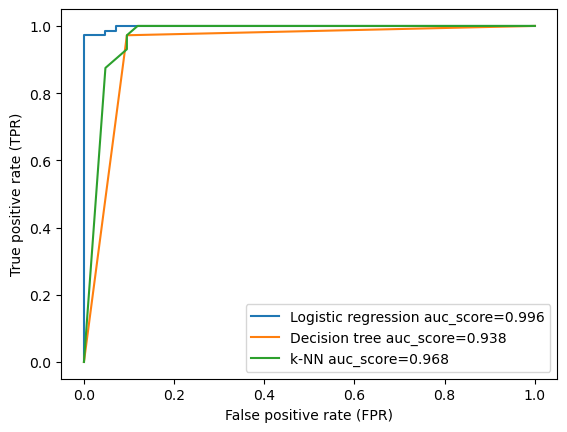

In [193]:
def roc_curve(clf, X, Y):
    K = 100
    theta = np.linspace(0, 1, K)

    y_pred = clf.predict_proba(X)
    tp_rate = np.sum((y_pred[:, 1, None] > theta) & Y[..., None], axis=0) / np.sum(Y)
    fp_rate = np.sum((y_pred[:, 1, None] > theta) & (Y[..., None] == 0), axis=0) / np.sum(Y == 0)
    
    idx = np.argsort(fp_rate)
    
    tp_rate = np.take_along_axis(tp_rate, idx, axis=0)
    fp_rate = np.take_along_axis(fp_rate, idx, axis=0)

    tp_rate[-1] = 1.0
    fp_rate[-1] = 1.0

    fpr_diff = np.diff(fp_rate)
    auc_score = np.sum(fpr_diff * (tp_rate[1:] + tp_rate[:-1]))/2
    return fp_rate, tp_rate, auc_score

fp_rate, tp_rate, auc_score = roc_curve(lr, X_test, Y_test)
sns.lineplot(x=fp_rate, y=tp_rate, estimator=None, label=f'Logistic regression {auc_score=:.3f}')

fp_rate, tp_rate, auc_score = roc_curve(dt, X_test, Y_test)
sns.lineplot(x=fp_rate, y=tp_rate, estimator=None, label=f'Decision tree {auc_score=:.3f}')

fp_rate, tp_rate, auc_score = roc_curve(kn, X_test, Y_test)
sns.lineplot(x=fp_rate, y=tp_rate, estimator=None, label=f'k-NN {auc_score=:.3f}')

plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.legend()

In [185]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, lr.predict_proba(X_test)[:, 1]), roc_auc_score(Y_test, dt.predict_proba(X_test)[:, 1]), roc_auc_score(Y_test, kn.predict_proba(X_test)[:, 1])

(0.9930555555555556, 0.9384920634920635, 0.9613095238095238)